In [1]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import os
import copy
import pickle
import gzip
import math
#plot
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib_venn import venn3
#import pygraphviz
import datetime
from itertools import combinations
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter
#for statistics
import statistics
from scipy.stats import chisquare,levene,ttest_ind,linregress
from scipy.stats import binomtest#ztest

In [3]:
#shared minicircles
def shared_mini(il,kpy,upk,strains=['IL3000','Kepeya','UPKZN']):
    def get_mini(seqdict):
        return set([k for k,v in seqdict.items()]) #.split('_v')[0]
    venn3([get_mini(il), get_mini(kpy), get_mini(upk)], strains)
    plt.show()
    print(len(get_mini(il).union(get_mini(kpy).union(get_mini(upk)))))
#length distribution
def length_distribution(seqs,colors={'IL3000':'r','Kepeya':'b','UPKZN':'orange'},start=700):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=False)
    for seqs,strain in zip(seqs,colors.keys()):
        lengths=[len(v.seq) for k,v in seqs.items()]
        ax.hist(lengths,bins=range(start,1100,10),alpha=0.3,label=strain,color=colors[strain])
        print(strain,min(lengths),max(lengths))
    ax.set_xlabel('minicircle class length')
    ax.set_ylabel('minicircle class count')
    ax.legend()
    plt.show()
    


In [4]:
il3000='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_minicircles.fasta'
kpy='/home/jovyan/Tcongo_PacBio/Infiles/Kepeya_minicircles.fasta'
upk='/home/jovyan/Tcongo_PacBio/Infiles/UPKZN_minicircles.fasta'
tc='/home/jovyan/Tcongo_PacBio/Infiles/Tc_0.97.minicircles.fasta'
copycsv='/home/jovyan/Tcongo_PacBio/Infiles/copy.20240430.csv'
depthcsv='/home/jovyan/Tcongo_PacBio/Infiles/depth.20240430.csv'
#read csv
cpdf=pd.read_csv(copycsv,index_col=0)
depth=pd.read_csv(depthcsv,index_col=0)
#read fasta
il=SeqIO.to_dict(SeqIO.parse(il3000,'fasta'))
kpy=SeqIO.to_dict(SeqIO.parse(kpy,'fasta'))
upk=SeqIO.to_dict(SeqIO.parse(upk,'fasta'))
tc=SeqIO.to_dict(SeqIO.parse(tc,'fasta'))

In [5]:
#find minicircles with alternative CSBs
CSB1=['GGGCGTTCA','GGGCGTGCA']
CSB3=['GGGGTTGGTGT','GGGGTTGATGT']
def find_mini(minis,csbs):
    alts={csb:[] for csb in csbs}
    for k,mini in minis.items():
        cons=mini.seq[:120]
        for csb in csbs:
            if csb in cons:
                alts[csb].append(k)
    return(alts)

#excecution
ilcsb1=find_mini(il,CSB1)
ilcsb3=find_mini(il,CSB3)
#
kpycsb1=find_mini(kpy,CSB1)
kpycsb3=find_mini(kpy,CSB3)
upkcsb1=find_mini(upk,CSB1)
upkcsb3=find_mini(upk,CSB3)
#check hetero
upkcsb1_hetero=['mO_144_v1','mO_18','mO_165','mO_279','mO_431']
print([i for i in upkcsb1_hetero if i in upkcsb1['GGGCGTGCA']])
upkcsb3_hetero=['mO_385','mO_411','mO_104_v1','mO_209']
print([i for i in upkcsb3_hetero if i in upkcsb3['GGGGTTGATGT']])


['mO_165', 'mO_279', 'mO_431']
['mO_411', 'mO_104_v1']


In [6]:
cpdf

,mO_88,mO_298_v1,mO_125_v1,mO_298_v2,mO_124_v1,mO_562_v1,mO_19,mO_367_v1,mO_21,mO_22,mO_26,mO_34,mO_06,mO_39,mO_45,mO_49,mO_66,mO_67,mO_68,mO_69,mO_65,mO_64,mO_84,mO_85,mO_86,mO_99,mO_52,mO_106,mO_46,mO_107,mO_108,mO_122,mO_123,mO_124_v2,mO_125_v2,mO_120,mO_126,mO_127,mO_149,mO_150,mO_151,mO_152,mO_153,mO_154,mO_155,mO_156,mO_157,mO_158,mO_159,mO_171,mO_172,mO_173,mO_179,mO_180,mO_181,mO_182,mO_183,mO_198,mO_163,mO_199,mO_218,mO_219,mO_234,mO_235,mO_236,mO_250,mO_251,mO_252,mO_253,mO_254,mO_255,mO_267,mO_268,mO_269,mO_191,mO_286,mO_287,mO_288,mO_289,mO_329,mO_189,mO_314,mO_315,mO_212,mO_325,mO_326,mO_327,mO_328,mO_260,mO_347,mO_335,mO_348,mO_332,mO_349,mO_366,mO_367_v2,mO_368,mO_369,mO_370,mO_371,mO_372,mO_373,mO_391,mO_392,mO_393,mO_394,mO_395,mO_396,mO_397,mO_412,mO_432,mO_387,mO_446,mO_447,mO_423,mO_448,mO_449,mO_450,mO_451,mO_463,mO_464,mO_478,mO_491,mO_492,mO_493,mO_494,mO_495,mO_505,mO_506,mO_507,mO_508,mO_509,mO_510,mO_511,mO_512,mO_528,mO_515,mO_501,mO_529,mO_530,mO_531,mO_532,mO_533,mO_545,mO_546,mO_554,mO_555,mO_556,mO_562_v2,mO_563,mO_564,mO_565,mO_566,mO_575,mO_597,mO_598,mO_599,mO_616,mO_617,mO_618,mO_460,mO_635,mO_636,mO_637,mO_638,mO_639,mO_644,mO_645,mO_651,mO_469,mO_657,mO_666,mO_667,mO_668,mO_669,mO_670,mO_673,mO_684,mO_691,mO_700,maxicircle,network_size,mO_06_v1,mO_06_v2,mO_137_v1,mO_72_v1,mO_90_v1,mO_80_v1,mO_200_v1,mO_435_v1,mO_204_v1,mO_20,mO_131_v1,mO_42,mO_43,mO_47,mO_50,mO_51,mO_57,mO_58,mO_59,mO_70,mO_71,mO_72_v2,mO_73,mO_80_v2,mO_81,mO_82,mO_87,mO_89,mO_90_v2,mO_91,mO_92,mO_100,mO_101,mO_102,mO_109,mO_110,mO_105,mO_111,mO_112,mO_113,mO_128,mO_129,mO_130,mO_131_v2,mO_132,mO_135,mO_136,mO_137_v2,mO_138,mO_139,mO_140,mO_141,mO_160,mO_161,mO_162,mO_174,mO_114,mO_184,mO_186,mO_187,mO_188,mO_200_v2,mO_32,mO_201,mO_202,mO_203,mO_204_v2,mO_196,mO_205,mO_206,mO_210,mO_220,mO_221,mO_222,mO_223,mO_224,mO_237,mO_238,mO_239,mO_240,mO_241,mO_242,mO_243,mO_244,mO_245,mO_248,mO_256,mO_257,mO_258,mO_259,mO_285,mO_270,mO_271,mO_272,mO_273,mO_274,mO_275,mO_276,mO_277,mO_278,mO_290,mO_291,mO_292,mO_293,mO_294,mO_295,mO_296,mO_297,mO_299,mO_316,mO_317,mO_318,mO_330,mO_331,mO_350,mO_351,mO_352,mO_353,mO_354,mO_355,mO_356,mO_306,mO_374,mO_343,mO_375,mO_376,mO_377,mO_378,mO_379,mO_380,mO_381,mO_382,mO_398,mO_399,mO_338,mO_400,mO_401,mO_402,mO_403,mO_404,mO_413,mO_414,mO_415,mO_416,mO_417,mO_418,mO_433,mO_434,mO_435_v2,mO_430,mO_436,mO_437,mO_438,mO_439,mO_440,mO_441,mO_442,mO_443,mO_452,mO_453,mO_454,mO_455,mO_456,mO_457,mO_458,mO_465,mO_466,mO_467,mO_468,mO_470,mO_471,mO_472,mO_473,mO_426,mO_474,mO_479,mO_480,mO_481,mO_482,mO_496,mO_497,mO_498,mO_513,mO_514,mO_516,mO_517,mO_534,mO_535,mO_536,mO_547,mO_548,mO_557,mO_567,mO_576,mO_577,mO_596,mO_586,mO_587,mO_588,mO_589,mO_600,mO_606,mO_607,mO_608,mO_619,mO_620,mO_621,mO_625,mO_613,mO_627,mO_628,mO_629,mO_630,mO_640,mO_646,mO_647,mO_652,mO_653,mO_654,mO_658,mO_660,mO_661,mO_665,mO_671,mO_674,mO_676,mO_679,mO_680,mO_681,mO_685,mO_686,mO_697,mO_701,mO_233_v1,mO_104_v1,mO_233_v2,mO_144_v1,mO_98_v1,mO_09,mO_10,mO_216_v1,mO_97_v1,mO_120_v1,mO_17,mO_18,mO_24,mO_27,mO_28,mO_29,mO_30,mO_31,mO_335_v1,mO_33,mO_36,mO_37,mO_38,mO_44,mO_48,mO_53,mO_54,mO_55,mO_56,mO_60,mO_61,mO_62,mO_63,mO_170,mO_74,mO_75,mO_76,mO_77,mO_78,mO_79,mO_83,mO_93,mO_94,mO_95,mO_96,mO_97_v2,mO_98_v2,mO_103,mO_104_v2,mO_115,mO_116,mO_117,mO_118,mO_119,mO_120_v2,mO_121,mO_133,mO_134,mO_142,mO_143,mO_144_v2,mO_145,mO_146,mO_147,mO_148,mO_164,mO_165,mO_166,mO_167,mO_168,mO_169,mO_175,mO_176,mO_177,mO_178,mO_190,mO_192,mO_193,mO_194,mO_195,mO_197,mO_207,mO_208,mO_209,mO_211,mO_213,mO_214,mO_215,mO_216_v2,mO_217,mO_204,mO_225,mO_226,mO_227,mO_228,mO_229,mO_230,mO_231,mO_232,mO_233_v3,mO_246,mO_247,mO_249,mO_261,mO_262,mO_263,mO_264,mO_265,mO_266,mO_279,mO_280,mO_281,mO_282,mO_283,mO_284,mO_300,mO_301,mO_302,mO_303,mO_304,mO_305,mO_307,mO_308,mO_309,mO_310,mO_311,mO_312,mO_346,mO_319,mO_320,mO_321,mO_322,mO_323,mO_324,mO_333,mO_334,mO_335_v2,mO_336,mO_337,mO_339,mO_340,mO_341,mO_342,mO_344,mO_345,mO_357,mO_358,mO_359,m

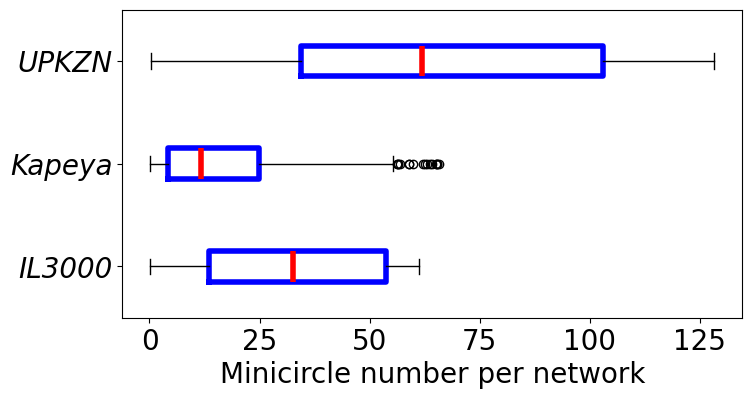

total MCN {'IL3000': 5829.160000000002, 'Kapeya': 4430.819999999999, 'UPKZN': 22771.84000000002}
standard deviation: {'IL3000': 20.54, 'Kapeya': 17.6, 'UPKZN': 38.28}
IL3000 vs Kapeya: 3.4478460602945236e-14
IL3000 vs UPKZN: 7.995585332280597e-27
Kapeya vs UPKZN: 2.044146345491077e-62
IL3000 mean: 32, median: 32.69, mode: 53.94, max: 61.23, min: 0.21
Kapeya mean: 18, median: 11.625, mode: 1.38, max: 65.71, min: 0.21
UPKZN mean: 67, median: 61.91, mode: 30.47, max: 128.25, min: 0.24
maxicircle: {'IL3000': 30.0, 'Kapeya': 30.0, 'UPKZN': 30.0}
1
8
2


In [7]:
def plot_minicircle_class_network_size(cpdf,feature,pcut=0.05):
    labels=cpdf.index
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    data={s: {k:v for k,v in zip(cpdf.columns,cpdf.loc[s].fillna(0)) if v!= 0} for s in cpdf.index}
    data={s:[v for k,v in data[s].items() if k not in ['maxicircle', 'network_size']] for s in data}
    #print(data)
    ax.boxplot(data.values(),labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'{feature}',fontsize=20)
    plt.show()
    print('total MCN',{s:sum(d) for s,d in data.items()})
    #standard deviation
    print('standard deviation:',{s:round(statistics.stdev(d),2) for s,d in data.items()})
    #t test
    for pair in combinations(labels, 2):
        t=ttest_ind(data[pair[0]], data[pair[1]])
        if t.pvalue<pcut:
            print(f"{pair[0]} vs {pair[1]}: {t.pvalue}")
    #minimum and maximum
    for k,v in data.items():
        mean=round(sum(v)/len(v))
        med=statistics.median(v)
        mod=statistics.mode(v)
        print(f"{k} mean: {mean}, median: {med}, mode: {mod}, max: {max(v)}, min: {min(v)}")
    print('maxicircle:',{s:cpdf.loc[s,'maxicircle'] for s in cpdf.index})
plot_minicircle_class_network_size(cpdf,'Minicircle number per network')
#<1 copy
data={s: {k:v for k,v in zip(cpdf.columns,cpdf.loc[s].fillna(0)) if v!= 0} for s in cpdf.index}
for s in data:
    print(len([k for k,v in data[s].items() if v<1]))

In [8]:
#Levene
print('levene test for equal variances')
statistic, pvalue = levene(cpdf.loc['IL3000'].dropna(),cpdf.loc['Kapeya'].dropna(),cpdf.loc['UPKZN'].dropna(), center='mean')
print(f'W = {statistic:.2f}, p = {pvalue:.2g}\n')

levene test for equal variances
W = 0.93, p = 0.4



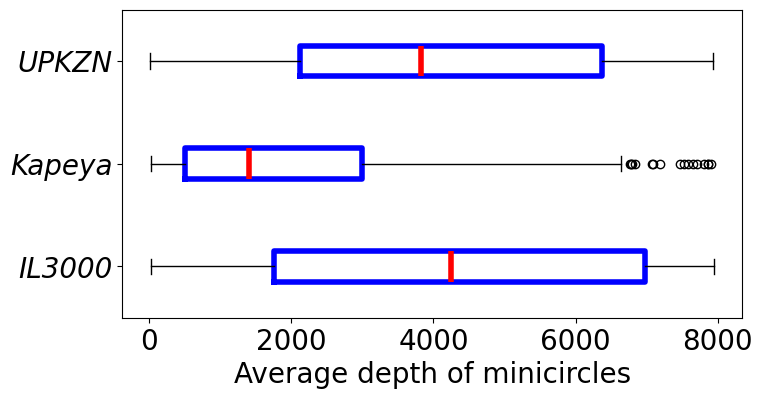

total MCN {'IL3000': 756898.2139303483, 'Kapeya': 532788.4577114423, 'UPKZN': 1408877.1492537316}
standard deviation: {'IL3000': 2667.17, 'Kapeya': 2116.45, 'UPKZN': 2368.26}
IL3000 vs Kapeya: 1.789806127033674e-17
Kapeya vs UPKZN: 3.7063252384900876e-24
IL3000 mean: 4205, median: 4244.7164179104475, mode: 7021.527363184079, max: 7950.089552238806, min: 27.691542288557216
Kapeya mean: 2148, median: 1398.1044776119402, mode: 3206.860696517413, max: 7901.497512437811, min: 24.855721393034827
UPKZN mean: 4156, median: 3830.26368159204, mode: 1935.1094527363184, max: 7934.601990049751, min: 14.696517412935323
maxicircle: {'IL3000': 4673.05248687828, 'Kapeya': 4837.651587103224, 'UPKZN': 2402.7813046738315}


In [9]:
plot_minicircle_class_network_size(depth,'Average depth of minicircles')

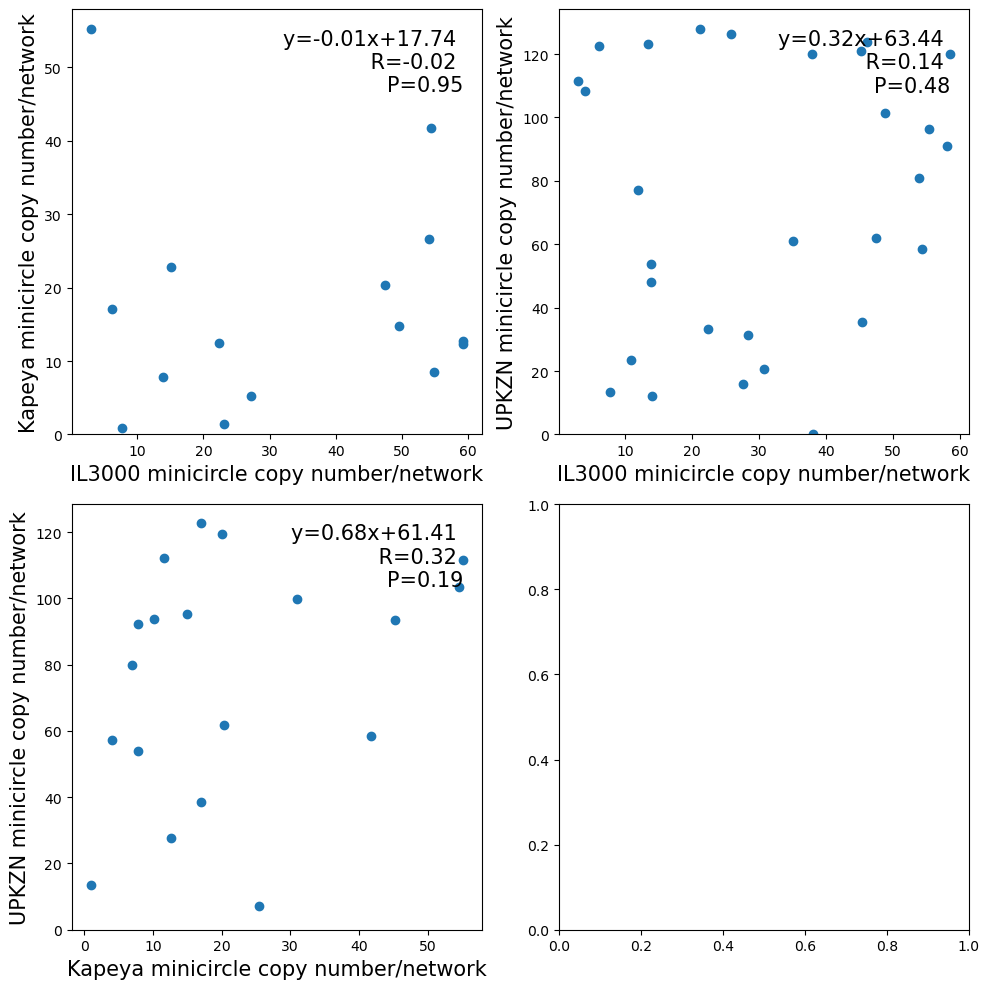

In [15]:
#check for correlation of shared minicircle classes
def copy_number_shared_mini(cpdf,strains=['IL3000','Kapeya','UPKZN']):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
    for i,pair in enumerate(combinations(strains, 2)):
        if i<2:
            ax=axs[0,i%2]
        else:
            ax=axs[1,i%2]
        df=cpdf.loc[[pair[0],pair[1]]].dropna(axis=1).drop(['maxicircle','network_size'], axis=1)
        #corr = round(np.corrcoef(df.loc[pair[0]],df.loc[pair[1]])[0,1],2)
        x=df.loc[pair[0]]
        y=df.loc[pair[1]]
        corr=linregress(x,y)
        ax.scatter(x,y)
        ax.set_ylim(bottom=0)
        ax.set_xlabel(f"{pair[0]} minicircle copy number/network",fontsize=15)
        ax.set_ylabel(f"{pair[1]} minicircle copy number/network",fontsize=15)
        #ax.text(max(x),max(y),f"R={corr}",ha='right')
        ax.text(max(x),max(y),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \nP={round(corr.pvalue,2)}",
                ha='right',va='top',fontsize=15)
    plt.tight_layout()
    plt.show()

copy_number_shared_mini(cpdf,strains=['IL3000','Kapeya','UPKZN'])

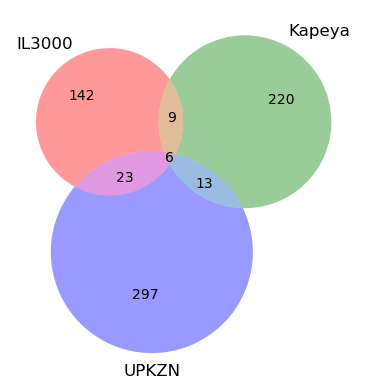

710


In [11]:
#show shared minicircles
shared_mini(il,kpy,upk,strains=['IL3000','Kapeya','UPKZN'])

mean: 952, median: 953.0, mode: 964, max: 985, min: 906
mean: 954, median: 954.0, mode: 949, max: 1052, min: 904
mean: 952, median: 953, mode: 950, max: 1001, min: 851
IL3000 906 985
Kepeya 904 1052
UPKZN 851 1001


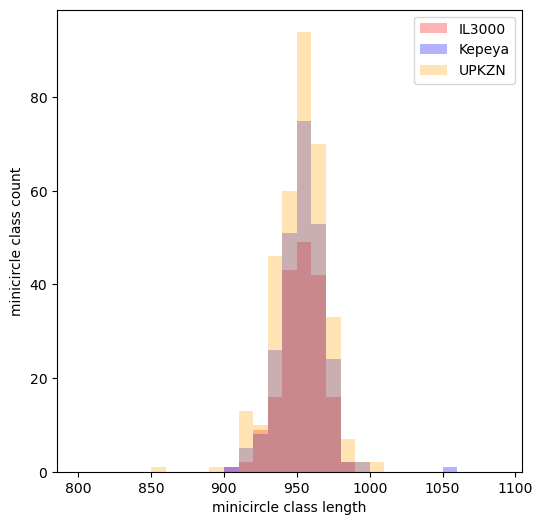

In [12]:
#length distribution
def mini_len_stats(fasta_dict):
    d=[len(v.seq) for k,v in fasta_dict.items()]
    mean=round(sum(d)/len(d))
    med=statistics.median(d)
    mod=statistics.mode(d)
    print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
for dct in [il,kpy,upk]:
    mini_len_stats(dct)
length_distribution([il,kpy,upk],start=800)

In [13]:
#CSB proportions
ilcsb1={'GGGCGTTCA': 113, 'GGGCGTGCA': 64}
ilcsb2={'AACCCGTAC': 95, 'ATCCCGTAC': 31, 'AACACGTAC': 5, 'ATCCCGTGT': 3, 'AACCCGTGC': 1, 'ATCCCGTGC': 1}
ilcsb3={'GGGGTTGGTGT': 178, 'GGGGTTGATGT': 5}
#
kpycsb1={'GGGCGTTCA': 153, 'GGGCGTGCA': 88}
kpycsb2={'AACCCGTAC': 125, 'ATCCCGTAC': 30, 'AACACGTAC': 9, 'AACCCGTGC': 3, 'ATCCCGTGT': 3, 'AAACCGTAC': 1}
kpycsb3={'GGGGTTGGTGT': 244, 'GGGGTTGATGT': 3}
#
upkcsb1={'GGGCGTTCA': 180, 'GGGCGTGCA': 154}
upkcsb2={'AACCCGTAC': 189, 'ATCCCGTAC': 35, 'AACACGTAC': 6, 'ATCCCGTGT': 2, 'AACCCGTGC': 2, 'ATCCCGTGC': 2}
upkcsb3={'GGGGTTGGTGT': 321, 'GGGGTTGATGT': 14}
#csb1
print(binomtest(ilcsb1['GGGCGTTCA'],180,kpycsb1['GGGCGTTCA']/248))
print(binomtest(ilcsb1['GGGCGTTCA'],180,upkcsb1['GGGCGTTCA']/248))
print(binomtest(kpycsb1['GGGCGTTCA'],248,upkcsb1['GGGCGTTCA']/248))

BinomTestResult(k=113, n=180, alternative='two-sided', statistic=0.6277777777777778, pvalue=0.8182194175226967)
BinomTestResult(k=113, n=180, alternative='two-sided', statistic=0.6277777777777778, pvalue=0.004362048020752589)
BinomTestResult(k=153, n=248, alternative='two-sided', statistic=0.6169354838709677, pvalue=0.00020122224071195062)
